In [30]:
# Standard library imports
import copy
import os
import random
import time
from datetime import datetime

# Third party imports
import cv2
import imgaug as ia
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from PIL import Image
from sklearn.metrics import accuracy_score
from torch import nn
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor

# Local application imports
from helper_functions import *

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
show_random_birbs(img_dir="bird-525/train")

In [ ]:
get_height_width(path="bird-525\\train\\RED BROWED FINCH\\001.jpg")

The image size is 224 x 224


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
num_classes = 0
for root, dirs, files in os.walk("birds-525\\train-subset"):
    num_classes += len(dirs)

print(f"There are {num_classes} types of brids in the train dataset.")

There are 0 types of brids in the train dataset.


In [ ]:
# Define a transform to convert the data to PyTorch Tensor
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize all images to 224x224
    transforms.ToTensor()
])

# Load the training data
train_data = datasets.ImageFolder(
    root="birds-525\\train-subset",
    transform=transform
)

val_data = datasets.ImageFolder(
    root="birds-525\\valid-subset",
    transform=transform
)


# Create a data loader
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=32, 
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_data, 
    batch_size=32,
    shuffle=False
)

In [ ]:
class BirbNet(nn.Module):
    def __init__(self, num_classes):
        super(BirbNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False

        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        return x

In [ ]:
model = BirbNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=3, gamma=0.2)

epochs = 3
patience = 2

model, loss_history = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, device, epochs, patience)

Step [10/39] | Loss: 1.6880232095718384 | Accuracy: 0.275
Step [20/39] | Loss: 1.279490351676941 | Accuracy: 0.4
Step [30/39] | Loss: 1.0429965257644653 | Accuracy: 0.5114583333333333
Epoch [1/3], Loss: 54.21716332435608, Accuracy: 0.5819209039548022, Validation Loss: 0.7173920571804047, Validation Accuracy: 0.875
Step [10/39] | Loss: 0.6950365900993347 | Accuracy: 0.88125
Step [20/39] | Loss: 0.5212661027908325 | Accuracy: 0.890625
Step [30/39] | Loss: 0.3564453125 | Accuracy: 0.9083333333333333
Epoch [2/3], Loss: 22.50523841381073, Accuracy: 0.9128329297820823, Validation Loss: 0.3561103641986847, Validation Accuracy: 0.925
Step [10/39] | Loss: 0.3727092742919922 | Accuracy: 0.940625
Step [20/39] | Loss: 0.4536702334880829 | Accuracy: 0.9390625
Step [30/39] | Loss: 0.3316865861415863 | Accuracy: 0.9385416666666667
Epoch [3/3], Loss: 14.819695770740509, Accuracy: 0.9322033898305084, Validation Loss: 0.2707165628671646, Validation Accuracy: 0.9


In [ ]:
save_model(model, "./models/birbnet.pt")

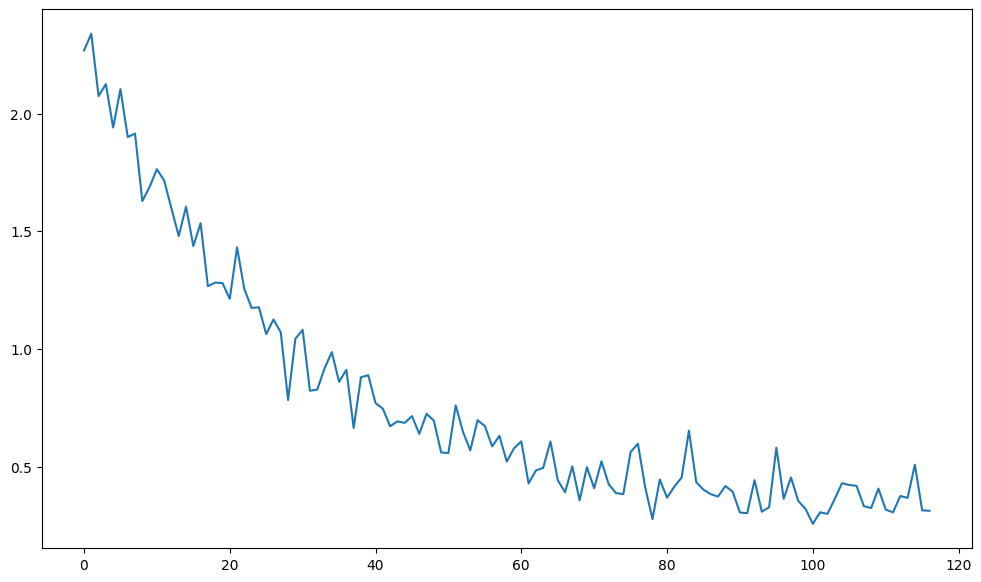

In [ ]:
plot_loss(loss_history, save=False)

## Classify new data

In [ ]:
def predict_image(model, image_path, show_image=False):
    # Ensure the model is in evaluation mode
    model.eval()

    # Load and preprocess the image
    image = Image.open(image_path)
    input_image = transform(image)
    input_image = input_image.unsqueeze(0)
    input_image = input_image.to(device)

    # Make the prediction
    with torch.no_grad():
        output = model(input_image)
        _, predicted_class = torch.max(output, 1)

    # Map the predicted class index to the corresponding class label
    predicted_class_label = train_data.classes[predicted_class.item()]

    if show_image:# Display the image and the prediction
        plt.imshow(image)
        plt.title(f'Predicted class: {train_data.classes[predicted_class.item()]}')
        plt.axis(False)
        plt.show()

    return predicted_class_label

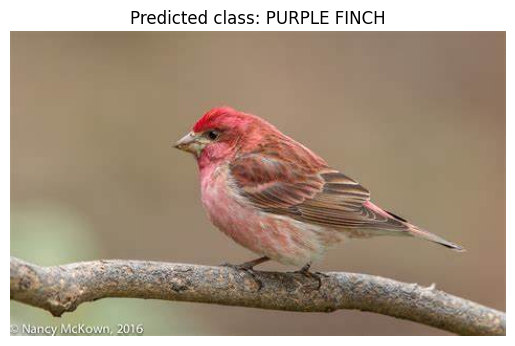

'PURPLE FINCH'

In [ ]:
predict_image(model, "birb-images/purple-finch.jpg", show_image=True)

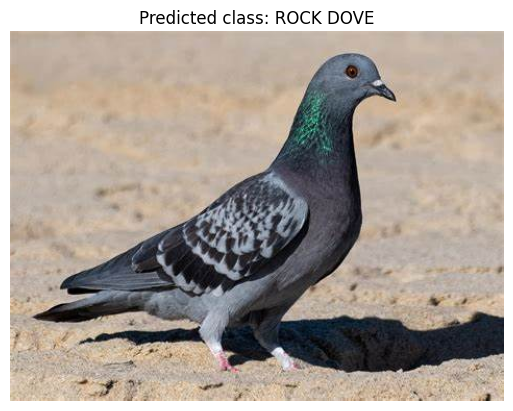

'ROCK DOVE'

In [ ]:
predict_image(model, "birb-images/rock-dove.jpg", show_image=True)

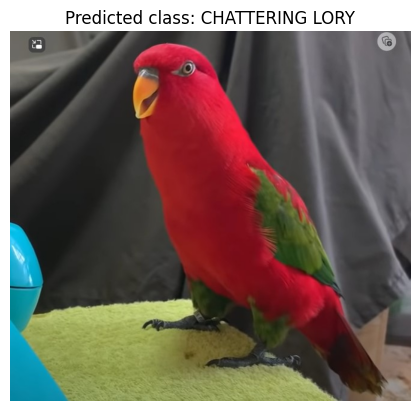

'CHATTERING LORY'

In [ ]:
predict_image(model, "birb-images/red-birb.jpg", show_image=True)

## Object detection on CUB 200-2011

In [52]:
# Standard library imports
import copy
import os
import random
import time
from datetime import datetime

# Third party imports
import cv2
import imgaug as ia
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from PIL import Image
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from torch import nn
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor
from torchvision.datasets.vision import VisionDataset
from torchvision.models.detection import FasterRCNN_MobileNet_V3_Large_320_FPN_Weights, FasterRCNN_MobileNet_V3_Large_FPN_Weights

# Local application imports
from engine import *
from engine_od import *

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

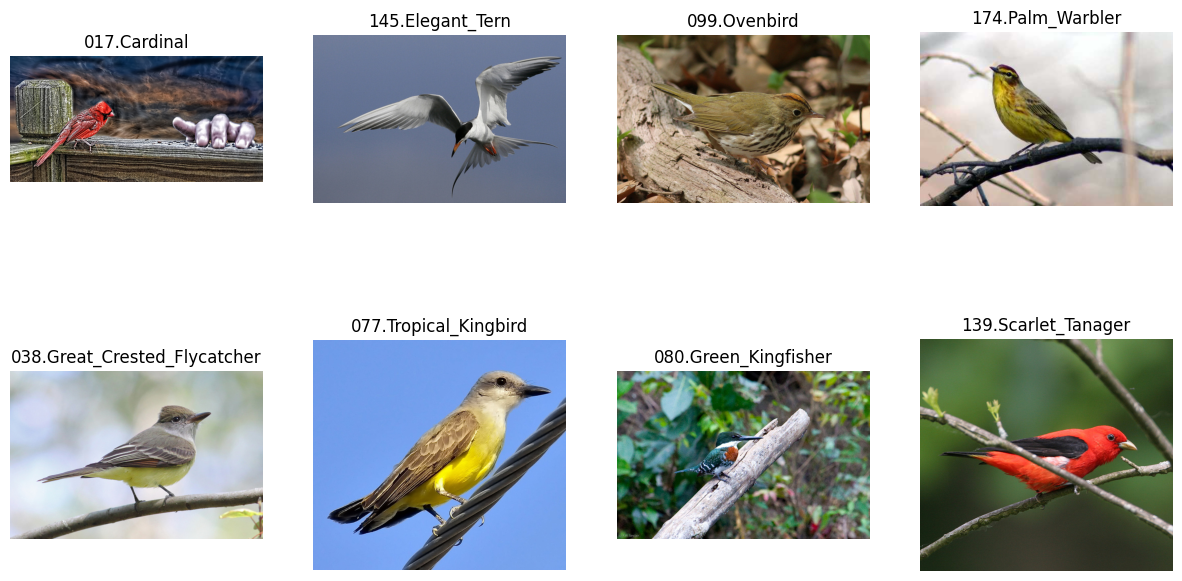

In [53]:
show_random_birbs(img_dir="./cub-200-2011/images")

In [54]:
get_height_width(path="./cub-200-2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.jpg")

The image size is 320 x 223


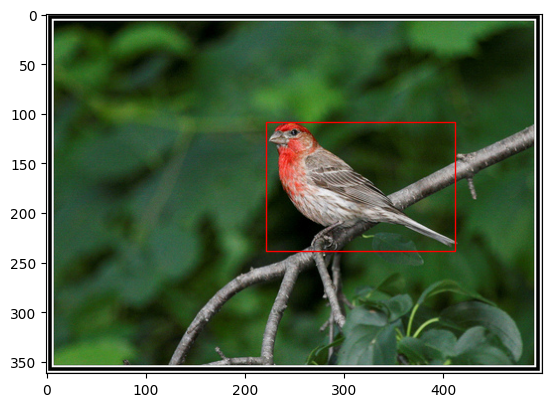

In [55]:
display_image_with_boxes("./cub-200-2011/images/035.Purple_Finch/Purple_Finch_0025_28174.jpg", [[221.0, 108.0, 191.0, 130.0]])


In [56]:
# Load the bounding boxes
bounding_boxes = pd.read_csv("cub-200-2011/bounding_boxes.txt", sep=" ", header=None)
bounding_boxes.columns = ["Image", "x", "y", "width", "height"]

# Convert the bounding box coordinates to float
bounding_boxes[["x", "y", "width", "height"]] = bounding_boxes[["x", "y", "width", "height"]].astype(float)

# Load the class labels
class_labels = pd.read_csv("cub-200-2011/image_class_labels.txt", sep=" ", header=None)
class_labels.columns = ["Image", "Label"]

# Merge the two dataframes on the Image column
data = pd.merge(class_labels, bounding_boxes, on='Image')

In [57]:
# Load the bounding boxes
bounding_boxes = pd.read_csv("cub-200-2011/bounding_boxes.txt", sep=" ", header=None)
bounding_boxes.columns = ["Image", "x", "y", "width", "height"]

# Convert the bounding box coordinates to float
bounding_boxes[["x", "y", "width", "height"]] = bounding_boxes[["x", "y", "width", "height"]].astype(float)

# Load the class labels
class_labels = pd.read_csv("cub-200-2011/image_class_labels.txt", sep=" ", header=None)
class_labels.columns = ["Image", "Label"]

# Merge the two dataframes on the Image column
data = pd.merge(class_labels, bounding_boxes, on='Image')

# Create a list of ones with the same length as your data
objectness_labels = [1] * len(data)

# Convert the list to a pandas Series
objectness_labels = pd.Series(objectness_labels, name="Objectness")

# Add the objectness labels to your data
data = pd.concat([data, objectness_labels], axis=1)

# Load the image paths
image_paths = pd.read_csv("cub-200-2011/images.txt", sep=" ", header=None)
image_paths.columns = ["Image", "Path"]

# Create a dictionary that maps image IDs to image paths
image_paths_dict = dict(zip(image_paths["Image"], image_paths["Path"]))

# Add the image paths to the data DataFrame
data['Image_Path'] = data['Image'].map(image_paths_dict)

# New size
new_size = 320

for i, row in data.iterrows():
    # Get the image path
    img_path = image_paths_dict.get(int(row["Image"]))

    # If the image file was found, open the image and get its size
    if img_path is not None:
        with Image.open(f"cub-200-2011/images/{img_path}") as img:
            original_width, original_height = img.size

        # Define bounding boxes
        bbs = BoundingBoxesOnImage([
            BoundingBox(x1=row['x'], x2=row['x']+row['width'], y1=row['y'], y2=row['y']+row['height'])
        ], shape=(original_height, original_width))

        # Rescale bounding boxes
        bbs_rescaled = bbs.on((new_size, new_size))

        # Update the bounding box coordinates in the DataFrame
        data.at[i, 'x'] = bbs_rescaled.bounding_boxes[0].x1
        data.at[i, 'y'] = bbs_rescaled.bounding_boxes[0].y1
        data.at[i, 'width'] = bbs_rescaled.bounding_boxes[0].width
        data.at[i, 'height'] = bbs_rescaled.bounding_boxes[0].height

In [58]:
data

,Image,Label,x,y,width,height,Objectness,Image_Path
0,1,1,38.399998,25.791044,208.000000,290.388062,1,001.Black_footed_Albatross/Black_Footed_Albatr...
1,2,1,88.959999,28.571430,97.920006,251.428574,1,001.Black_footed_Albatross/Black_Footed_Albatr...
2,3,1,8.960000,103.285301,248.319992,171.527374,1,001.Black_footed_Albatross/Black_Footed_Albatr...
3,4,1,86.361450,57.600002,196.626495,154.879990,1,001.Black_footed_Albatross/Black_Footed_Albatr...
4,5,1,67.673714,42.105263,129.546814,255.157898,1,001.Black_footed_Albatross/Black_Footed_Albatr...
...,...,...,...,...,...,...,...,...
11783,11784,200,60.724945,74.692871,241.535187,196.560211,1,200.Common_Yellowthroat/Common_Yellowthroat_00...
11784,11785,200,100.480003,59.579578,117.759987,210.450455,1,200.Common_Yellowthroat/Common_Yellowthroat_00...
11785,11786,200,121.599998,86.121368,126.720009,170.554077,1,200.Common_Yellowthroat/Common_Yellowthroat_00...
11786,11787,200,1.920000,19.219219,261.119995,295.015045,1,200.Common_Yellowthroat/Common_Yellowthroat_00...


In [59]:
class BirdDataset(VisionDataset):
    def __init__(self, root, data, transform=None, target_transform=None):
        super().__init__(root, transform=transform, target_transform=target_transform)
        
        # Load the image paths and labels from images.txt
        self.images = pd.read_csv(os.path.join(root, 'images.txt'), sep=' ', names=['id', 'path'])
        self.data = data

    def __getitem__(self, index):
        # Get the image path and label from the dataframe
        img_path, label = self.images.iloc[index]
        
        # Load the image
        img = Image.open(os.path.join(self.root, img_path)).convert('RGB')
        
        # Apply the transform if there is one
        if self.transform is not None:
            img = self.transform(img)

        # Convert the label to an integer
        label = int(label)

        # Extract only the number from the image name
        image_number = img_path.split('.')[0].lstrip('0')

        # Get the bounding box for this image
        bbox = self.data[self.data['Image'] == int(image_number)][['x', 'y', 'width', 'height']].values[0]

        # Convert the bounding box to [x1, y1, x2, y2] format
        bbox = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]

        # Create a target dictionary
        target = {}
        target["boxes"] = torch.as_tensor([bbox], dtype=torch.float32)  # there is only one box per image
        target["labels"] = torch.as_tensor([label], dtype=torch.int64)  # assuming that the label is of type `int`
        target["image_id"] = torch.tensor([index])  # unique image id
        target["area"] = torch.tensor([(bbox[3] - bbox[1]) * (bbox[2] - bbox[0])], dtype=torch.float32)  # area of the bounding box
        target["iscrowd"] = torch.zeros((1,), dtype=torch.int64)  # assume there are no crowd in dataset

        return img, target

    def __len__(self):
        return len(self.images)

In [60]:
use_classes = ["035.Purple_Finch", "047.American_Goldfinch", "017.Cardinal", "118.House_Sparrow"]

# Define the number of classes you want to keep
num_classes = len(use_classes)

# Create a new directory for the subset of classes
subset_dir = "cub-200-2011/subset"

# If the subset directory already exists, delete it
if os.path.exists(subset_dir):
    shutil.rmtree(subset_dir)
os.makedirs(subset_dir, exist_ok=True)

# Get the list of class directories
class_dirs = sorted(os.listdir("cub-200-2011/images"))

# Keep only the directories in use_classes
class_dirs = [dir for dir in class_dirs if dir in use_classes]

# Copy the directories in use_classes to the new directory
for class_dir in class_dirs:
    shutil.copytree(os.path.join("cub-200-2011/images", class_dir), os.path.join(subset_dir, class_dir))

# Load the images.txt file into a DataFrame
images_df = pd.read_csv('cub-200-2011/images.txt', sep=' ', names=['id', 'path'])
images_df['class'] = images_df['path'].apply(lambda x: x.split('/')[0])

# Filter the DataFrame to only include the selected classes
subset_df = images_df[images_df['class'].isin(use_classes)]

# Create a mapping from original class IDs to new class IDs
# Here, we add 1 to the new_id because you want the new class IDs to start from 1
class_mapping = {class_name: new_id + 1 for new_id, class_name in enumerate(sorted(use_classes))}

# Map the original class IDs to the new class IDs
subset_df['class'] = subset_df['class'].map(class_mapping)

subset_df.to_csv(os.path.join(subset_dir, 'images.txt'), sep=' ', index=False, header=False)

C:\Users\Leo\AppData\Local\Temp\ipykernel_23604\4081116983.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['class'] = subset_df['class'].map(class_mapping)


In [61]:
subset_df

,id,path,class
895,896,017.Cardinal/Cardinal_0038_19203.jpg,1
896,897,017.Cardinal/Cardinal_0072_17159.jpg,1
897,898,017.Cardinal/Cardinal_0085_19162.jpg,1
898,899,017.Cardinal/Cardinal_0047_17673.jpg,1
899,900,017.Cardinal/Cardinal_0094_17165.jpg,1
...,...,...,...
6905,6906,118.House_Sparrow/House_Sparrow_0033_112590.jpg,4
6906,6907,118.House_Sparrow/House_Sparrow_0104_113105.jpg,4
6907,6908,118.House_Sparrow/House_Sparrow_0098_111073.jpg,4
6908,6909,118.House_Sparrow/House_Sparrow_0011_112099.jpg,4


In [94]:
transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
    transforms.ToTensor(),
])

dataset = BirdDataset(subset_dir, data, transform=transform)

# Create the dataloader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn, num_workers=0, pin_memory=True)

In [95]:
len(dataset)

237

In [96]:
dataset[236]

(tensor([[[0.7490, 0.7529, 0.7529,  ..., 0.7961, 0.8000, 0.8039],
          [0.7294, 0.7490, 0.7451,  ..., 0.8078, 0.8196, 0.8196],
          [0.7216, 0.7333, 0.7294,  ..., 0.8314, 0.8431, 0.8392],
          ...,
          [0.6275, 0.6235, 0.6275,  ..., 0.5216, 0.5490, 0.5765],
          [0.6235, 0.6235, 0.6275,  ..., 0.5294, 0.5451, 0.5725],
          [0.6275, 0.6275, 0.6314,  ..., 0.5176, 0.5412, 0.5725]],
 
         [[0.6980, 0.7176, 0.7373,  ..., 0.8275, 0.8431, 0.8471],
          [0.6902, 0.7216, 0.7333,  ..., 0.8235, 0.8471, 0.8471],
          [0.6824, 0.7059, 0.7176,  ..., 0.8392, 0.8588, 0.8627],
          ...,
          [0.7961, 0.7922, 0.7961,  ..., 0.6784, 0.6902, 0.7059],
          [0.7922, 0.7922, 0.7961,  ..., 0.6824, 0.6863, 0.7020],
          [0.7961, 0.7961, 0.8000,  ..., 0.6706, 0.6784, 0.7020]],
 
         [[0.5333, 0.5412, 0.5569,  ..., 0.9216, 0.9529, 0.9608],
          [0.5294, 0.5490, 0.5608,  ..., 0.9059, 0.9412, 0.9490],
          [0.5412, 0.5608, 0.5686,  ...,

In [97]:
# Assuming that 'img_tensor' is your image tensor
img_tensor = dataset[0][0]

# Create the transform
to_pil = transforms.ToPILImage()

# Apply the transform to the tensor
img = to_pil(img_tensor)

# Now 'img' is a PIL image, you can use 'img.show()' to display it
img.show()

In [66]:
class BirdNetOD(nn.Module):
    def __init__(self, num_classes):
        super(BirdNetOD, self).__init__()

        # Load the pretrained Faster R-CNN model
        self.model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights)
        self.model.roi_heads.detections_per_img = 1

        # Get the number of input features for the classifier
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features

        # Replace the pre-trained head with a new one
        self.model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    def forward(self, images, targets=None):
        return self.model(images, targets)

In [75]:
from torchinfo import summary 

def freeze_params_except_classifier(model):
    # Iterate over all the parameters of the model
    for name, param in model.named_parameters():
        # If the parameter is not part of the classifier
        if not name.startswith("model.roi_heads.box_predictor"):
            # Freeze the parameter
            param.requires_grad = False

# Create an instance of the BirdNetOD model
model = BirdNetOD(num_classes=num_classes+1).to(device)

# Freeze the parameters of the model except the classifier
freeze_params_except_classifier(model)

# Print the summary of the model
print(summary(model))

c:\Users\Leo\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                                       Param #
BirdNetOD                                                    --
├─FasterRCNN: 1-1                                            --
│    └─GeneralizedRCNNTransform: 2-1                         --
│    └─BackboneWithFPN: 2-2                                  --
│    │    └─IntermediateLayerGetter: 3-1                     (2,947,552)
│    │    └─FeaturePyramidNetwork: 3-2                       (1,467,392)
│    └─RegionProposalNetwork: 2-3                            --
│    │    └─AnchorGenerator: 3-3                             --
│    │    └─RPNHead: 3-4                                     (609,355)
│    └─RoIHeads: 2-4                                         --
│    │    └─MultiScaleRoIAlign: 3-5                          --
│    │    └─TwoMLPHead: 3-6                                  (13,895,680)
│    │    └─FastRCNNPredictor: 3-7                           25,625
Total params: 18,945,604
Trainable params: 25,625
Non-traina

In [103]:
state_dict = torch.load("./models/birbnet-4-fasterrcnn-mobilenet-fpn-epoch-135.pt")
model.load_state_dict(state_dict)
model = model.to(device)

In [99]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

model.backbone.body.0.0.weight False
model.backbone.body.1.block.0.0.weight False
model.backbone.body.1.block.1.0.weight False
model.backbone.body.2.block.0.0.weight False
model.backbone.body.2.block.1.0.weight False
model.backbone.body.2.block.2.0.weight False
model.backbone.body.3.block.0.0.weight False
model.backbone.body.3.block.1.0.weight False
model.backbone.body.3.block.2.0.weight False
model.backbone.body.4.block.0.0.weight False
model.backbone.body.4.block.1.0.weight False
model.backbone.body.4.block.2.fc1.weight False
model.backbone.body.4.block.2.fc1.bias False
model.backbone.body.4.block.2.fc2.weight False
model.backbone.body.4.block.2.fc2.bias False
model.backbone.body.4.block.3.0.weight False
model.backbone.body.5.block.0.0.weight False
model.backbone.body.5.block.1.0.weight False
model.backbone.body.5.block.2.fc1.weight False
model.backbone.body.5.block.2.fc1.bias False
model.backbone.body.5.block.2.fc2.weight False
model.backbone.body.5.block.2.fc2.bias False
model.back

In [100]:
# Choose the right optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Number of epochs
num_epochs = 150

for epoch in range(num_epochs):
    print(f"Starting epoch {epoch+1} of {num_epochs}")
    # Train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, dataloader, device, epoch=epoch, print_freq=10)

    # Update the learning rate
    scheduler.step()

    # Save the state dictionaries every 5 epochs
    if epoch % 5 == 0:
        torch.save(model.state_dict(), f'./models/birbnet-4-fasterrcnn-mobilenet-fpn-epoch-{epoch}.pt')


Starting epoch 1 of 150
Epoch: [0]  [ 0/60]  eta: 0:00:15  lr: 0.000018  loss: 0.9996 (0.9996)  loss_classifier: 0.5286 (0.5286)  loss_box_reg: 0.4207 (0.4207)  loss_objectness: 0.0427 (0.0427)  loss_rpn_box_reg: 0.0075 (0.0075)  time: 0.2603  data: 0.0330  max mem: 550
Epoch: [0]  [10/60]  eta: 0:00:04  lr: 0.000187  loss: 1.0893 (1.1067)  loss_classifier: 0.6518 (0.5865)  loss_box_reg: 0.4780 (0.4491)  loss_objectness: 0.0591 (0.0632)  loss_rpn_box_reg: 0.0075 (0.0078)  time: 0.0865  data: 0.0208  max mem: 550
Epoch: [0]  [20/60]  eta: 0:00:03  lr: 0.000357  loss: 1.2659 (1.1866)  loss_classifier: 0.6693 (0.6173)  loss_box_reg: 0.5228 (0.4864)  loss_objectness: 0.0681 (0.0748)  loss_rpn_box_reg: 0.0089 (0.0081)  time: 0.0711  data: 0.0205  max mem: 550
Epoch: [0]  [30/60]  eta: 0:00:02  lr: 0.000526  loss: 0.8425 (1.0555)  loss_classifier: 0.3888 (0.5429)  loss_box_reg: 0.4059 (0.4226)  loss_objectness: 0.0996 (0.0813)  loss_rpn_box_reg: 0.0094 (0.0086)  time: 0.0733  data: 0.0215  m

KeyboardInterrupt: 

In [21]:
torch.save(model.state_dict(), "./models/birbnet-40-fasterrcnn-mobilenet-fpn-epoch-22-v2.pt")

torch.Size([3, 320, 320])
[{'boxes': tensor([[ 33.8624,  47.4101, 162.8861, 252.3163]], device='cuda:0'), 'labels': tensor([4], device='cuda:0'), 'scores': tensor([0.6463], device='cuda:0')}]
4
tensor([[ 33.8624,  47.4101, 162.8861, 252.3163]], device='cuda:0')


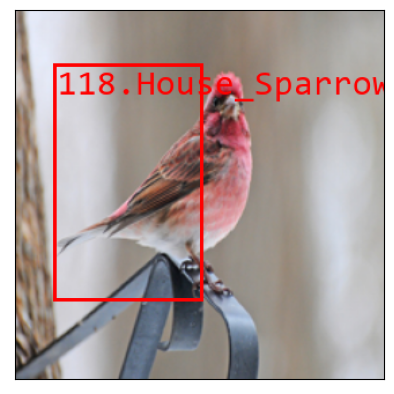

In [109]:
inf_transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
    transforms.ToTensor(),
])

display_prediction_with_boxes(model, "birb-images/goldfinch.jpg", inf_transform, class_labels=use_classes)